# Liesel-GAM Demo Notebook

## Setup and Imports

In [ ]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

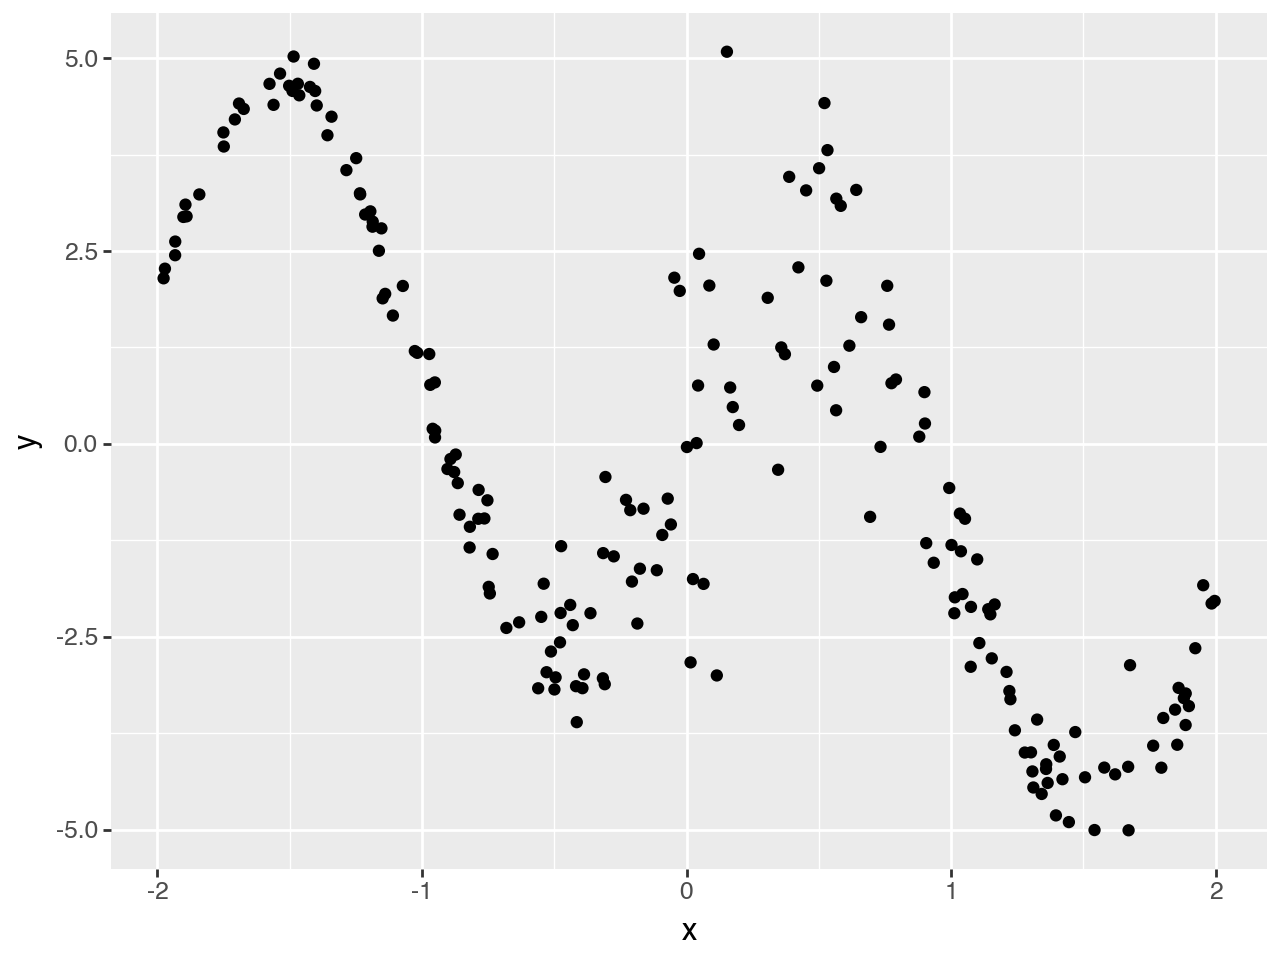

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [4]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)

loc += tb.ps("x")
scale += tb.ps("x")

### Build and plot model

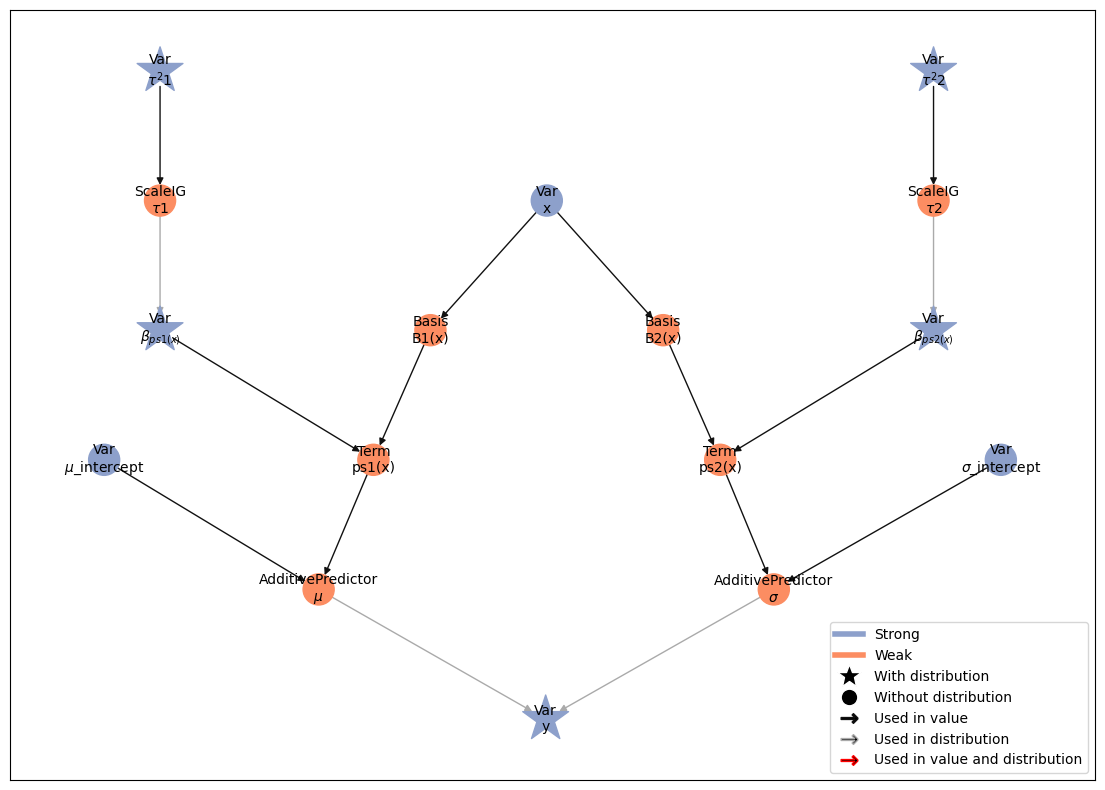

In [5]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [6]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\beta_{ps2(x)}$', '$\\tau^2$2', '$\\mu$_intercept', '$\\beta_{ps1(x)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:05<00:00,  3.09chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1225.33chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████

### MCMC summary

In [7]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)   kernel_04 -0.246696  0.409834 -0.922989 -0.237257   
                   (1,)   kernel_04 -0.017330  0.373262 -0.623883 -0.021947   
                   (2,)   kernel_04  0.396498  0.385439 -0.201457  0.384860   
                   (3,)   kernel_04  0.172051  0.368857 -0.429433  0.158230   
                   (4,)   kernel_04  0.141127  0.342888 -0.400594  0.136654   
                   (5,)   kernel_04  0.163616  0.323656 -0.353215  0.161188   
                   (6,)   kernel_04  0.008071  0.315860 -0.504296  0.002753   
                   (7,)   kernel_04 -0.066947  0.284494 -0.539084 -0.065627   
                   (8,)   kernel_04  0.068026  0.279009 -0.381456  0.064127   
                   (9,)   kernel_04  0.107613  0.243067 -0.283092  0.104748   
                   (10,)  kernel_04  0.138718  0.229558 -0.243772  0.147041   
                   (11,)  kernel_04 -0.119934  0.197758 -0.449217 -0.117995   
                   (12,)  kernel_04  0.313209  0.172894  0.030360  0.314224   
                   (13,)  kernel_04 -0.048207  0.137305 -0.268507 -0.052458   
                   (14,)  kernel_04  1.348630  0.105938  1.179858  1.347347   
                   (15,)  kernel_04  0.035876  0.070612 -0.078095  0.034949   
                   (16,)  kernel_04  0.120204  0.039864  0.055657  0.120277   
                   (17,)  kernel_04  0.014311  0.016572 -0.012534  0.014194   
                   (18,)  kernel_04 -0.316049  0.062313 -0.418292 -0.316102   
$\beta_{ps2(x)}$   (0,)   kernel_01 -0.005746  0.085698 -0.144991 -0.004811   
                   (1,)   kernel_01  0.009927  0.085072 -0.122448  0.008176   
                   (2,)   kernel_01 -0.001632  0.083044 -0.135914 -0.002092   
                   (3,)   kernel_01  0.001432  0.080819 -0.127256  0.001274   
                   (4,)   kernel_01 -0.014725  0.082076 -0.155719 -0.012244   
                   (5,)   kernel_01  0.006606  0.081991 -0.123106  0.004312   
                   (6,)   kernel_01  0.017127  0.081847 -0.110282  0.014129   
                   (7,)   kernel_01 -0.031156  0.082130 -0.178457 -0.025066   
                   (8,)   kernel_01  0.025144  0.079009 -0.100000  0.022843   
                   (9,)   kernel_01  0.000742  0.074713 -0.121522 -0.000271   
                   (10,)  kernel_01 -0.007041  0.071504 -0.121512 -0.007290   
                   (11,)  kernel_01 -0.004810  0.066959 -0.115555 -0.005052   
                   (12,)  kernel_01  0.079324  0.067755 -0.021960  0.075350   
                   (13,)  kernel_01 -0.081727  0.059669 -0.187181 -0.078733   
                   (14,)  kernel_01  0.055648  0.050093 -0.024273  0.054406   
                   (15,)  kernel_01  0.081929  0.036390  0.023797  0.081363   
                   (16,)  kernel_01 -0.003171  0.022116 -0.039205 -0.003077   
                   (17,)  kernel_01 -0.043651  0.009766 -0.059198 -0.043817   
                   (18,)  kernel_01  0.142726  0.038538  0.078450  0.142953   
$\mu$_intercept    ()     kernel_03 -0.322027  0.057566 -0.416540 -0.323366   
$\sigma$_intercept ()     kernel_00 -0.631354  0.052999 -0.716909 -0.632949   
$\tau^2$1          ()     kernel_05  0.198344  0.094172  0.096147  0.177617   
$\tau^2$2          ()     kernel_02  0.007023  0.005351  0.002199  0.005616   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter          index                                                    
$\beta_{ps1(x)}$   (0,)   0.415477         4000  3217.065906  3729.266595   
                   (1,)   0.579623         4000  3592.408687  3599.973890   
                   (2,)   1.060297         4000  3223.890967  3594.030521   
                   (3,)   0.784633         4000  3528.303219  3581.382471   
                   (4,)   0.712978       

### MCMC trace plots

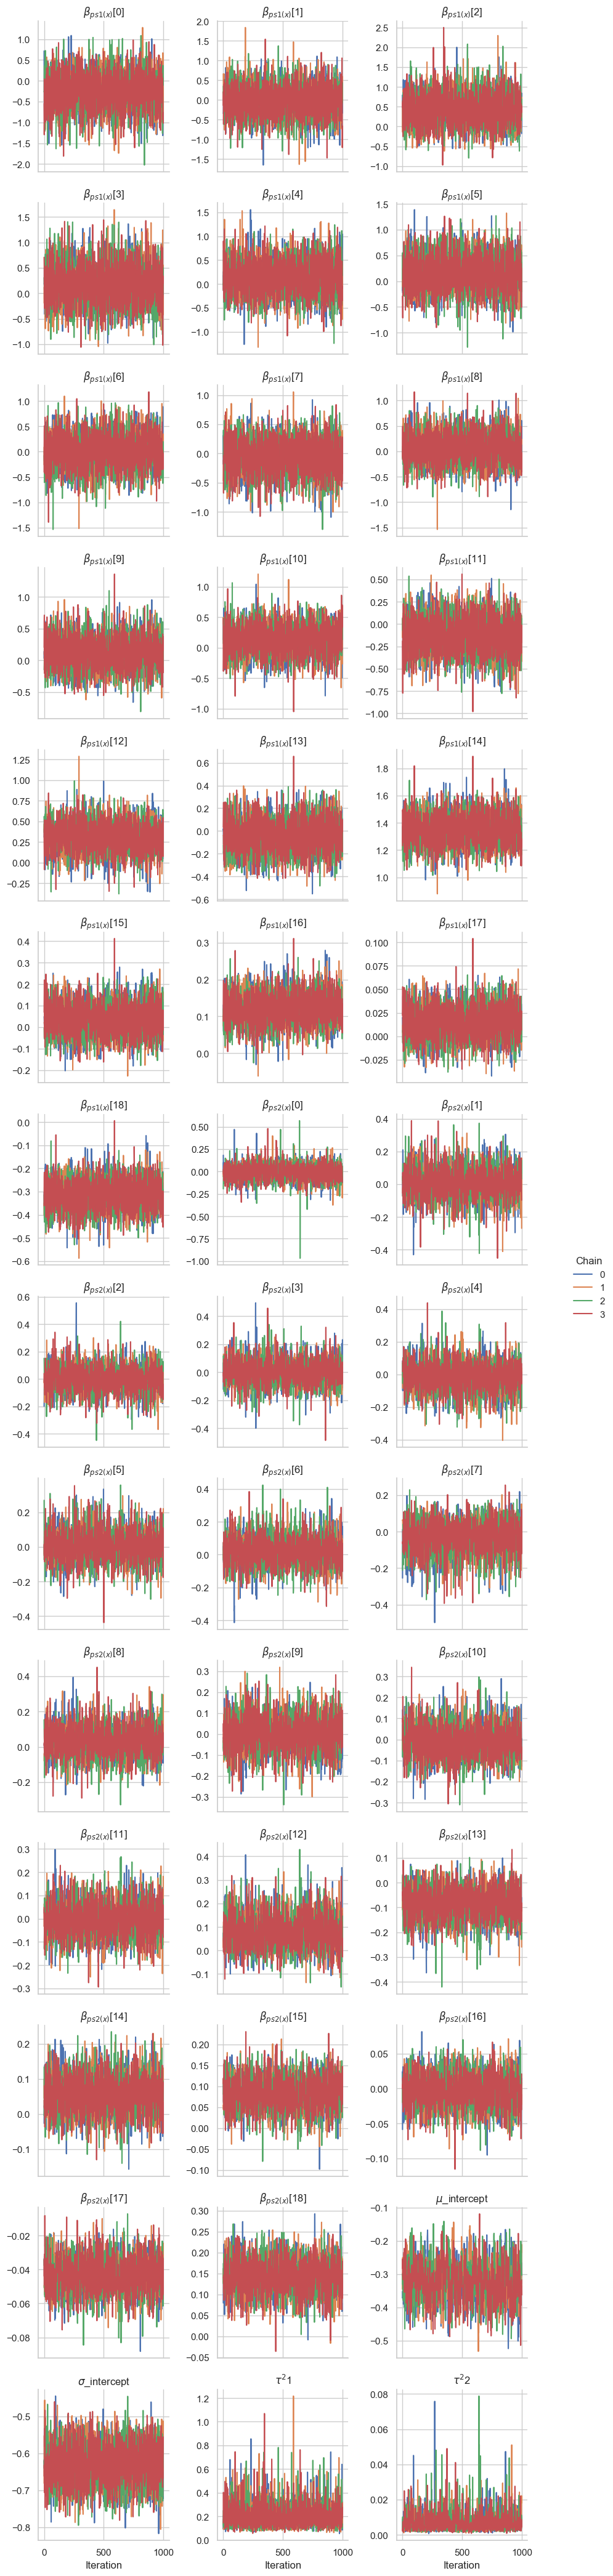

In [8]:
gs.plot_trace(results)

## Predictions

In [9]:
samples = results.get_posterior_samples()

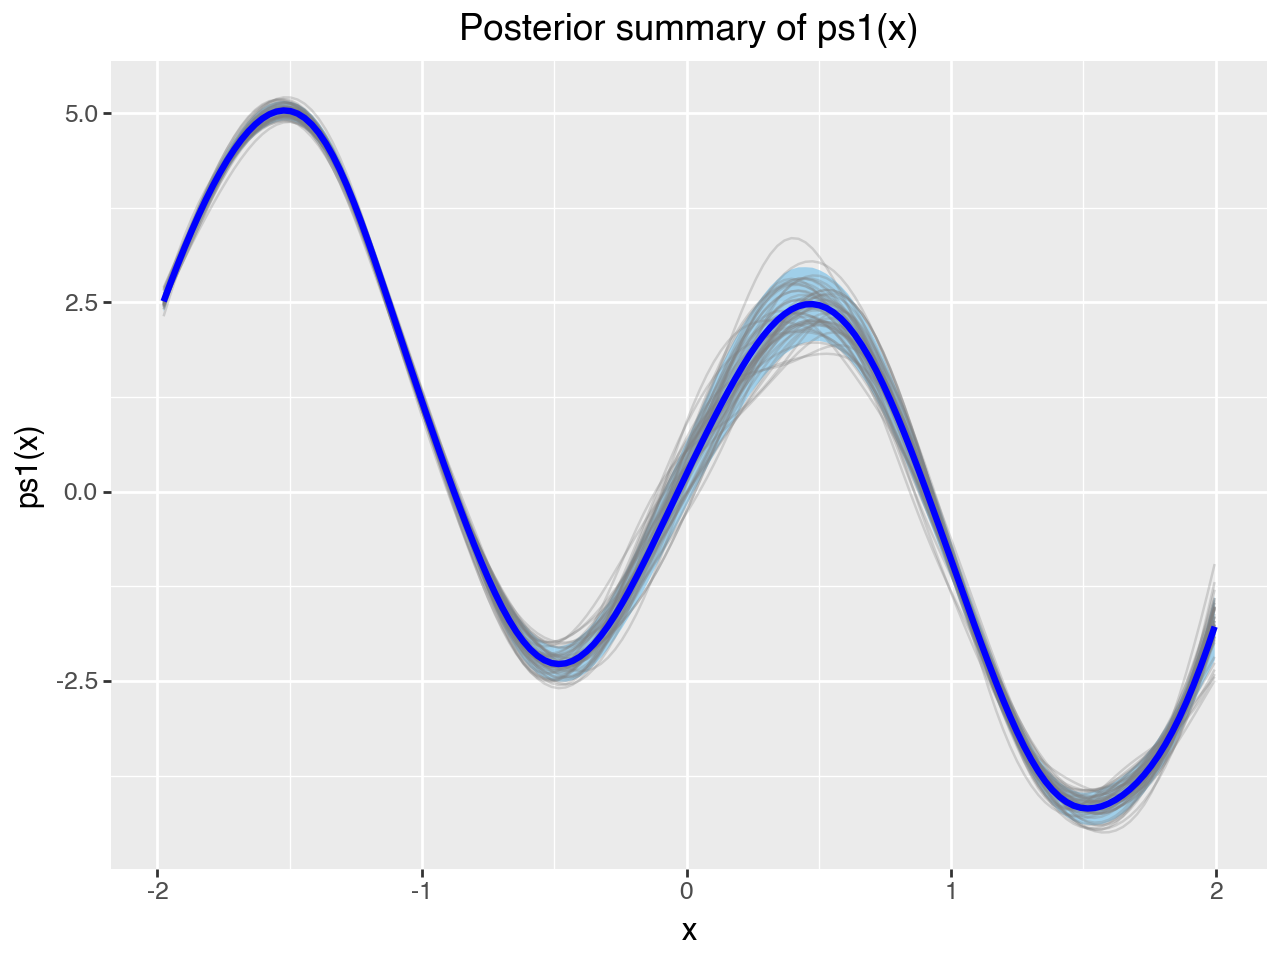

In [ ]:
gam.plot_1d_smooth(term=model.vars["ps1(x)"], samples=samples)

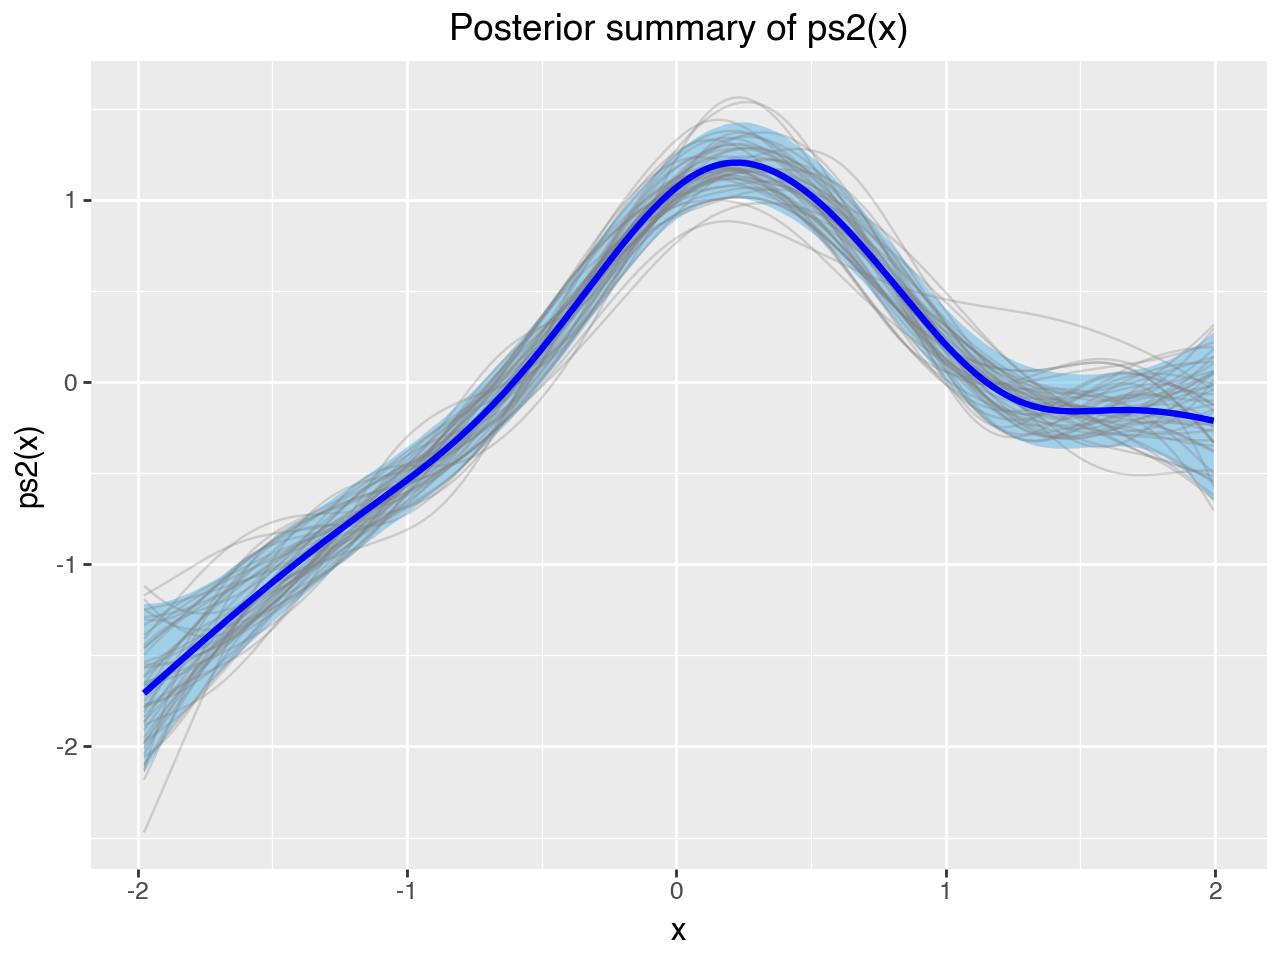

In [11]:
gam.plot_1d_smooth(term=model.vars["ps2(x)"], samples=samples)